In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)

In [3]:
from lib.tqdm_streamer import TokenProgressStreamer
from lib.chain_of_thought import extract_chain_of_thought
from lib.soft_stop_thinking import get_soft_stop_thinking_fn
from lib.do_you_know_quote_prompt import build_prompt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json
import re
import torch
from nnsight import LanguageModel
import nnsight

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
MODEL_NAME = 'Qwen/Qwen3-32B'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = LanguageModel(MODEL_NAME, dtype=torch.bfloat16, device_map=device)
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=8192, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=8192, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (up_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (down_proj): Linear(in_features=25600, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_la

# Evaluate eagerness vector

In [6]:
def get_layer_activations(prompt: str, pos: int = -1) -> torch.Tensor:
    messages = [{"role": "assistant", 'content': f'<think>{prompt}'}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False, continue_final_message=True
    )

    layer_activations = []

    with torch.no_grad():
        with model.trace(formatted_prompt):
            for layer in model.model.layers:
                activation = layer.output[0, pos, :].save()
                layer_activations.append(activation.cpu())

    result = torch.stack(layer_activations).cpu()

    return result

In [15]:
eagerness_prompts = pd.read_csv('dataset/eagerness_prompts.csv')
eagerness_prompts.prompt = eagerness_prompts.prompt.str.rstrip('.,!?')
print(eagerness_prompts['category'].value_counts().to_dict())
eagerness_prompts

{'eager': 157, 'cautious': 156}


,category,prompt
0,eager,You must answer no matter what
1,eager,You must find the answer
2,eager,Your response should be as helpful as possible
3,eager,It's absolutely necessary to find an answer
4,eager,Do everything you can to help
...,...,...
308,cautious,Don't answer beyond your knowledge boundary
309,cautious,Correctness is the true goal
310,cautious,Stay committed to accuracy
311,cautious,Avoiding wrong answers is valuable


In [16]:
activations = torch.stack(
    [get_layer_activations(prompt) for prompt in tqdm(eagerness_prompts.prompt.values)],
)

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:28<00:00, 10.82it/s]


In [17]:
eager_indices = eagerness_prompts[eagerness_prompts.category == 'eager'].index.tolist()
cautious_indices = eagerness_prompts[eagerness_prompts.category == 'cautious'].index.tolist()

In [18]:
eagerness_by_layer = activations[eager_indices].mean(axis=0) - activations[cautious_indices].mean(axis=0)  # type: ignore
normalized_eagerness = eagerness_by_layer / torch.norm(eagerness_by_layer, dim=-1, keepdim=True)

In [19]:
projections = (activations * normalized_eagerness.unsqueeze(0)).sum(dim=-1)

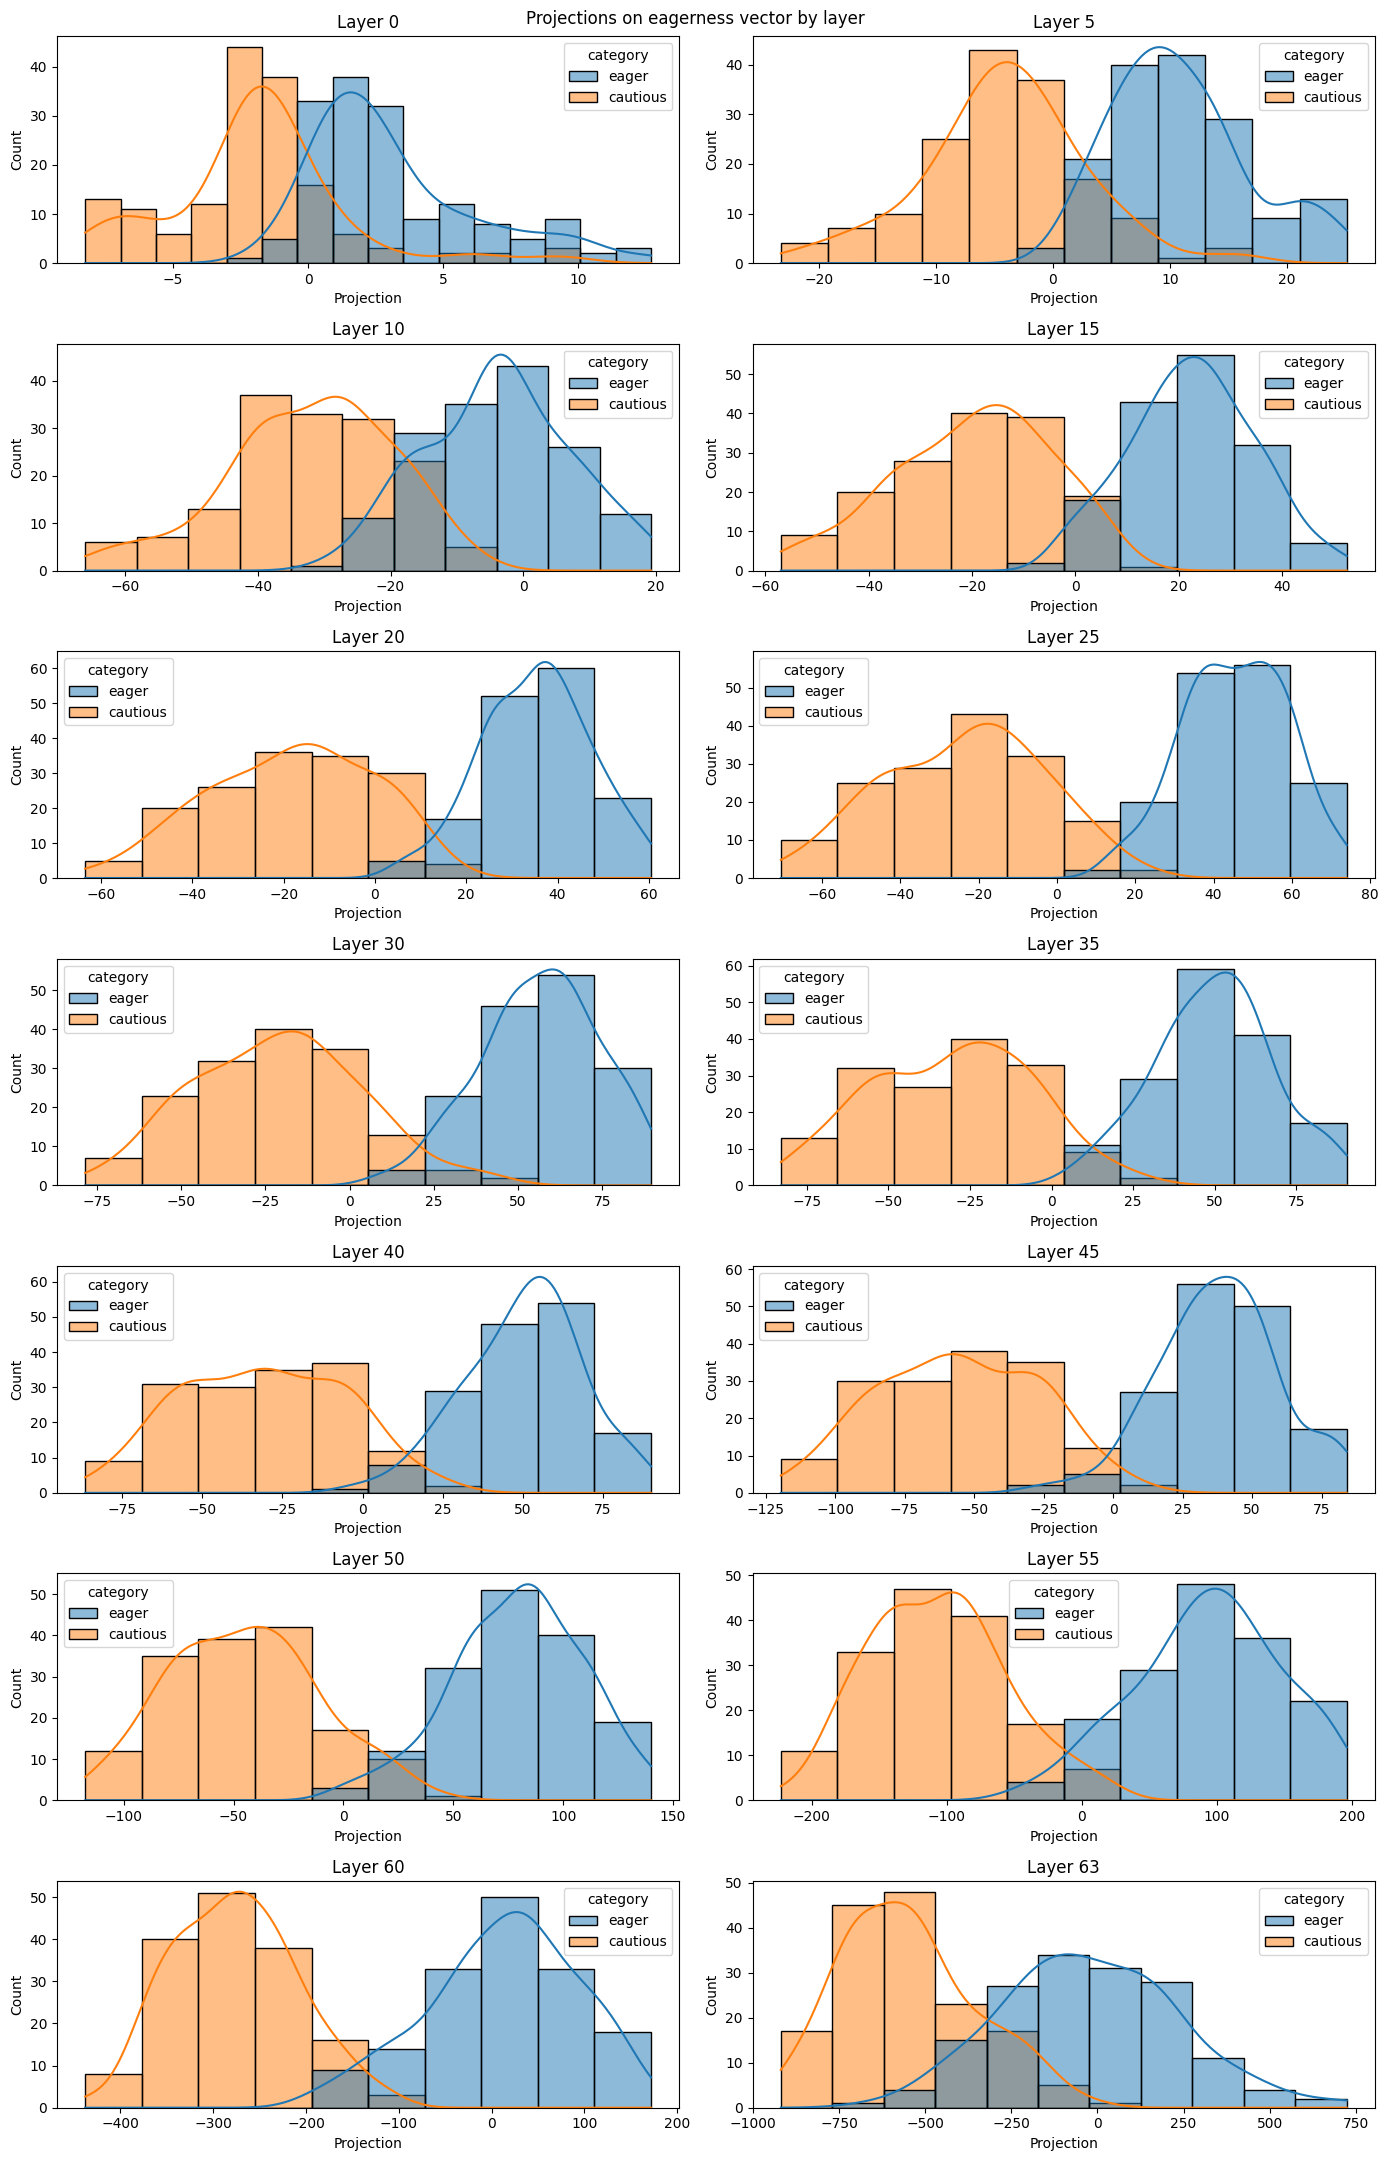

In [20]:
layers = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 63]
fig, axes = plt.subplots(7, 2, figsize=(14, 22))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    data = pd.concat([eagerness_prompts, pd.DataFrame({'projection': projections[:, layer].tolist()})], axis=1)
    sns.histplot(data, x='projection', hue='category', kde=True, ax=axes[idx])
    axes[idx].set_title(f'Layer {layer}')
    axes[idx].set_xlabel('Projection')
    axes[idx].set_ylabel('Count')

plt.suptitle('Projections on eagerness vector by layer')
plt.tight_layout()
plt.show()

In [21]:
separability_by_layer = (projections[eager_indices].std(dim=0) + projections[cautious_indices].std(dim=0)) / (
    (projections[eager_indices].mean(dim=0) - projections[cautious_indices].mean(dim=0))
).abs()

most_separable_layer = separability_by_layer.argmin().item()

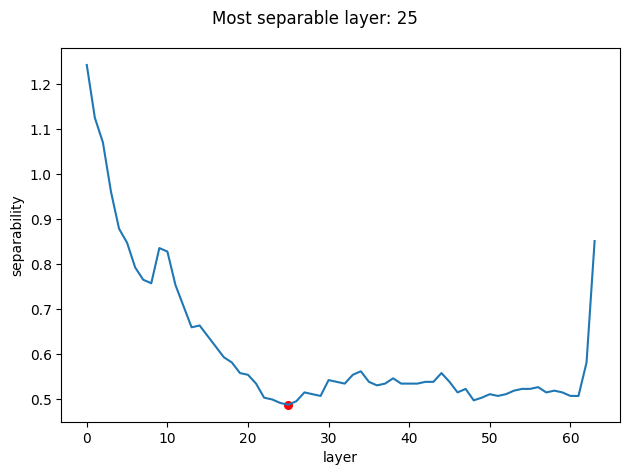

In [22]:
data = pd.Series(separability_by_layer.tolist()).to_frame(name='separability').reset_index(names=['layer'])
sns.lineplot(data, x='layer', y='separability')
plt.scatter(x=[most_separable_layer], y=[separability_by_layer[most_separable_layer].item()], color='red', s=30)
plt.suptitle(f'Most separable layer: {most_separable_layer}')
plt.tight_layout()
plt.show()

In [23]:
eagerness_vector = normalized_eagerness[most_separable_layer]
eager_projection = projections[eager_indices][most_separable_layer].mean().item()
cautious_projection = projections[cautious_indices][most_separable_layer].mean().item()

with open('dataset/eagerness_vector.json', 'w') as out:
    data = {
        'eagerness_vector': eagerness_vector.tolist(),
        'most_separable_layer': most_separable_layer,
        'eager_projection': eager_projection,
        'cautious_projection': cautious_projection,
    }
    json.dump(data, out)

In [5]:
with open('dataset/eagerness_vector.json', 'r') as inp:
    data = json.load(inp)
    eagerness_vector = torch.tensor(data['eagerness_vector'], dtype=torch.bfloat16)

# Plot eagerness of generated tokens

In [6]:
def generate_and_project(
    prompt: str,
    direction: torch.Tensor,
    abduct_direction_to: float | None = None,
    enable_thinking: bool = True,
    max_new_tokens: int = 32768,
    thinking_budget: int = 32768,
    layer_no: int = -1,
    random_state: int = 42,
    temperature: float = 0.6,
    top_p: float = 0.95,
    top_k: int = 20,
    samples: int = 1,
    **generate_kwargs,
) -> list[dict]:
    messages = [{'role': 'user', 'content': prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
    )

    input_token_length = len(tokenizer.encode(formatted_prompt))
    prefix_allowed_tokens_fn = (
        get_soft_stop_thinking_fn(
            tokenizer=tokenizer,
            thinking_budget=thinking_budget,
            input_length=input_token_length,
            model_vocab_size=model.config.vocab_size,
        )
        if enable_thinking
        else None
    )

    direction = direction.to(device)

    if abduct_direction_to is not None:

        def abduct_direction(activations: torch.Tensor):
            return (
                activations
                - activations @ direction.unsqueeze(0).T @ direction.unsqueeze(0)
                + abduct_direction_to * direction.unsqueeze(0)
            )

    projections = []
    logits = []
    generated_ids = []

    torch.manual_seed(random_state)
    with torch.no_grad():
        with model.generate(
            [formatted_prompt] * samples,
            max_new_tokens=max_new_tokens,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            **generate_kwargs,
        ) as tracer:
            with tracer.all():
                generated_ids.append(model.model.embed_tokens.input.save())

                if abduct_direction_to is not None:
                    for layer in model.model.layers:
                        layer.post_attention_layernorm.input = abduct_direction(layer.post_attention_layernorm.input)
                        layer.output = abduct_direction(layer.output)

                layer = model.model.layers[layer_no]
                projections.append((layer.output @ direction).save())

                logits.append(model.lm_head.output.save())

    projections = torch.cat(projections, dim=1)
    logits = torch.cat(logits, dim=1)
    generated_ids = torch.cat(generated_ids, dim=1)

    result = []
    for i in range(samples):
        generated_ids_sample = generated_ids[i].tolist()

        chain_of_thought, answer, thinking_duration = extract_chain_of_thought(
            generated_ids_sample[input_token_length:],
            tokenizer=tokenizer,
        )

        result.append(
            {
                'answer': answer,
                'chain_of_thought': chain_of_thought,
                'input_token_length': input_token_length,
                'thinking_duration': thinking_duration,
                'tokens': generated_ids_sample,
                'projections': projections[i].tolist(),
                'logits': logits[i].tolist(),
            }
        )

    return result

In [7]:
def test_quote_knowledge(
    quote: str,
    direction: torch.Tensor,
    abduct_direction_to: float | None = None,
    enable_thinking: bool = True,
    random_state: int = 42,
    max_new_tokens: int = 2048,
    samples: int = 1,
    layer_no: int = -1,
) -> list[dict]:
    prompt = build_prompt(quote)
    thinking_budget = max_new_tokens - 128 if enable_thinking else 0

    generated_samples = generate_and_project(
        prompt=prompt,
        direction=direction,
        abduct_direction_to=abduct_direction_to,
        enable_thinking=enable_thinking,
        max_new_tokens=max_new_tokens,
        thinking_budget=thinking_budget,
        top_p=1.0,
        random_state=random_state,
        samples=samples,
        layer_no=layer_no,
    )

    def get_info(sample_index: int, sample: dict):
        thinking_duration = sample['thinking_duration']
        input_token_length = sample['input_token_length']
        tokens = sample['tokens']
        logits = sample['logits']
        answer = sample['answer']
        chain_of_thought = sample['chain_of_thought']
        projections = sample['projections']

        generated_ids = tokens[input_token_length:]
        thinking_completed = thinking_duration < thinking_budget

        YES = tokenizer.vocab['Yes']
        NO = tokenizer.vocab['No']

        position = next(
            (pos for pos in range(thinking_duration, len(generated_ids)) if generated_ids[pos] in [YES, NO]), None
        )
        if position is None:
            print('No answer found')
            return {
                'quote': quote,
                'sample_index': sample_index,
                'random_state': random_state,
                'enable_thinking': enable_thinking,
                'thinking_completed': thinking_completed,
                'thinking_duration': thinking_duration,
                'max_new_tokens': max_new_tokens,
                'answer': answer,
                'chain_of_thought': chain_of_thought,
            }

        yes_logit = logits[position][YES]
        no_logit = logits[position][NO]

        positive_difference = yes_logit - no_logit
        positive_probability = 1 / (1 + np.exp(-positive_difference))

        return {
            'quote': quote,
            'sample_index': sample_index,
            'positive_probability': positive_probability,
            'positive_difference': positive_difference,
            'yes_logit': yes_logit,
            'no_logit': no_logit,
            'random_state': random_state,
            'input_token_length': input_token_length,
            'enable_thinking': enable_thinking,
            'thinking_completed': thinking_completed,
            'thinking_duration': thinking_duration,
            'max_new_tokens': max_new_tokens,
            'answer': answer,
            'chain_of_thought': chain_of_thought,
            'abduct_direction_to': abduct_direction_to,
            'layer_no': layer_no,
            'tokens': tokens,
            'projections': projections,
        }

    return [get_info(index, sample) for index, sample in enumerate(generated_samples)]

# Abduct eagerness

In [35]:
demo_quote = (
    "Eighteen months you've been sleeping in my bed, and today I find out you're married with three kids in Toledo?!"
)

In [36]:
result = test_quote_knowledge(
    demo_quote,
    eagerness_vector,
    max_new_tokens=1024,
    samples=10,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i977` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [37]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. Yes, the phrase is from *Meet the Parents* (2000). It is delivered by Teri Polo's character, Teri, during a confrontational scene with Greg Focker (played by Ben Stiller), as she accuses him of deception.
1. Yes, the phrase is from *Problem Child* (1990), a comedy film starring Richard Jeni and Kim Basinger. The line is delivered by Basinger's character, Sharon, during a dramatic confrontation with the titular mischievous "child" (Jeni in disguise), revealing the absurd twist that he is actually an adult in a child's body.
2. No, origin is unclear.
3. Yes, the phrase is from *Bruce Almighty* (2003), where the character Morgan (played by Amanda Peet) delivers this line to Bruce (Jim Carrey) during a heated confrontation.
4. Yes, the phrase is from *The Office* (U.S. version), specifically from Season 9, Episode 23 ("The Cover Up"), where Michael Scott (Steve Carell) delivers a dramatic and confrontational line to Dwight Schrute (Rainn Wilson) during a tense moment. The reference to T

In [38]:
print(result[2]['chain_of_thought'])

<think>
Okay, so the user is asking about the origin of the phrase: "Eighteen months you've been sleeping in my bed, and today I find out you're married with three kids in Toledo?!" I need to figure out where this comes from.

First, I'll try to recall if I've heard this line before. It sounds like a dramatic or confrontational statement, maybe from a movie or a TV show. The mention of Toledo is a specific detail, which might be a clue. Toledo is a city in Ohio, USA, so maybe it's a reference to an American production.

I'm thinking of possible shows or movies with such a line. The phrasing seems like it could be from a soap opera or a drama. Alternatively, it might be from a sitcom where a character is caught in a lie or a secret. The mention of being married with three kids suggests a revelation that's shocking to the speaker.

I'm trying to remember if any famous actors or actresses have delivered a line like this. Maybe someone like Courteney Cox or Jennifer Aniston, but I'm not su

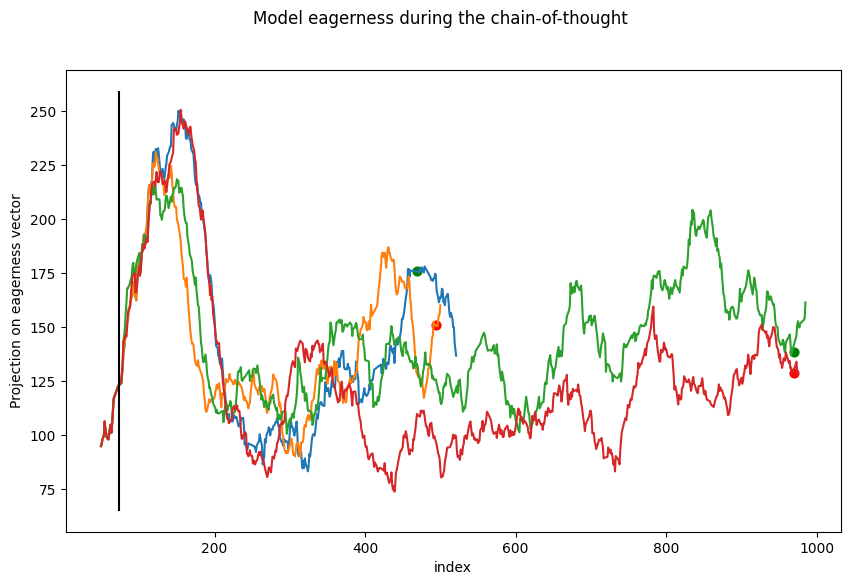

In [40]:
plt.figure(figsize=(10, 6))

for item in [result[0], result[2], result[5], result[6]]:
    data = pd.DataFrame({'projection': item['projections'], 'token': item['tokens']}).reset_index(names=['index'])
    data['symbol'] = data.token.apply(tokenizer.decode)
    data['is_alphabetical'] = data.symbol.str.contains('[a-zA-Z]') & ~data.symbol.str.startswith('<')
    data['projection_smoothened'] = data[data.is_alphabetical].projection.rolling(40).mean().reindex(data.index)

    # sns.lineplot(data.iloc[1:], x='layer', y='projection')
    sns.lineplot(data.iloc[1:], x='index', y='projection_smoothened')
    prompt_and_thinking = item['input_token_length'] + item['thinking_duration']
    smoothened_projection_at_boundary = data.projection_smoothened.ffill().iloc[prompt_and_thinking]
    positive_probability = item['positive_probability']
    plt.scatter(
        [prompt_and_thinking - 0.5],
        [smoothened_projection_at_boundary],
        color='green' if positive_probability > 0.5 else 'red',
        s=40,
    )

plt.vlines([item['input_token_length'] - 0.5], *plt.ylim(), color='k')
plt.ylabel('Projection on eagerness vector')
plt.suptitle(f'Model eagerness during the chain-of-thought')
plt.show()

# Abduct eagerness

In [46]:
result = test_quote_knowledge(
    demo_quote,
    eagerness_vector,
    abduct_direction_to=0,
    max_new_tokens=512,
    samples=4,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i497` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [47]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. No, origin is unclear.
1. Yes, the phrase is from the TV show *Friends* (Season 1, Episode 17: "The One with the Morning After"). In the episode, Rachel breaks up with her boyfriend Barry, and he accuses her of "sleeping in [his] bed" for months without commitment, later revealing he is married and has children. The reference to "Toledo" is a fictional detail added for comedic effect and does not correspond to real characters or plotlines. The phrase has since been misattributed to other sources in internet folklore.
2. No, origin is unclear.
3. No, origin is unclear.


In [48]:
print(result[1]['chain_of_thought'])

<think>
Okay, let's see. The user is asking about the origin of the phrase: "Eighteen months you've been sleeping in my bed, and today I find out you're married with three kids in Toledo?!" I need to recall if this is from a specific source.

First, I remember that the general idea of "sleeping in the bed" as a euphemism for relationships without marriage is a common theme in media. But Toledo? Maybe that's a reference to a particular context. I think the phrase might be from a movie or a TV show. Wait, the Toledo part is a real city, but in some contexts, "Toledo" is used as a placeholder for a generic location, similar to "Oshkosh" in some jokes.

I think this line is from the TV show "Friends." There's an episode where Rachel breaks up with Barry, and he accuses her of not being committed. But I'm not sure if that's where this specific line comes from. Alternatively, could it be from "The Office"? Or maybe a stand-up comedy bit?

Wait, another angle: the phrase "Three kids in Toledo

In [49]:
[item['positive_probability'] for item in result]

[np.float64(0.01243165085318582),
 np.float64(0.8354835371034369),
 np.float64(0.09534946489910949),
 np.float64(0.2689414213699951)]

Text(0.5, 0.98, 'Abducted projection')

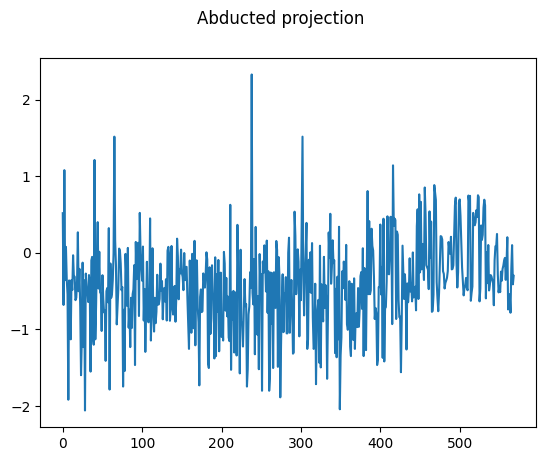

In [50]:
plt.plot(result[0]['projections'][1:])
plt.suptitle('Abducted projection')

# Load data

In [8]:
df = pd.concat(
    [pd.read_csv('dataset/movie_quotes_sometimes_correct.csv'), pd.read_csv('dataset/often_hallucinating.csv')],
    ignore_index=True,
)
df['correct_ratio'] = df['correct_ratio'].fillna(0)
df

,quote,title,correct_ratio,attempted_ratio,positive_probability
0,I live my life a quarter mile at a time.,The Fast and the Furious,0.4,1.0,1.000000
1,You only live twice:Once when you are born And...,You only live twice,0.3,1.0,1.000000
2,Ask any racer. Any real racer. It don't matter...,The Fast and The Furious,0.1,1.0,0.999976
3,The greatest thing you’ll ever learn is just t...,Moulin Rouge,0.1,1.0,0.999805
4,"I remember the story of an evil witch, at the ...",Maleficent,0.5,1.0,0.999490
5,"Well, I’ve got no leashes, or fences. With me,...",The Lady and the Tramp,0.1,0.9,0.964120
6,An idea is like a virus. Resilient. Highly con...,Inception,0.3,0.9,0.939586
7,It's not about what I want. It's about what's...,The Dark Knight,0.1,0.9,0.898785
8,Leave One Wolf Alive and the Sheep are Never Safe,Game of Thrones Season 7,0.1,0.6,0.730845
9,"When all seems lost, a few brave souls can sav...",Transformers,0.1,0.4,0.453989


# Debug

In [154]:
demo_quote = df.iloc[10].quote
demo_quote

"I never realized how much I loved being home unless I'd been somewhere really different for awhile."

In [ ]:
result = test_quote_knowledge(
    demo_quote,
    eagerness_vector,
    abduct_direction_to=15.0,
    max_new_tokens=512,
    samples=4,
)

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i430` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)


In [161]:
for index, item in enumerate(result):
    print(f'{index}.', item['answer'])

0. Yes, the phrase is from *Harry Potter and the Order of the Phoenix* by J.K. Rowling.
1. Yes, the phrase is from *Friends* (2004) - Season 10, Episode 24, "The Last One." It is spoken by Ross Geller during the series finale.
2. Yes, the phrase is from *The Pursuit of Happyness* (2006), spoken by Chris Gardner (played by Will Smith) in a reflective monologue about appreciating home after being away.
3. Yes, the phrase is from *The Hobbit* by J.R.R. Tolkien. It is spoken by the character Bilbo Baggins, reflecting his sentiment about the value of home after his adventures.


In [162]:
print(result[2]['chain_of_thought'])

<think>
Okay, let's see. The user is asking about the origin of the phrase: "I never realized how much I loved being home unless I'd been somewhere really different for awhile." They want to know if I can identify the source. If I don't know, I should say "No, origin is unclear." If I do know, then "Yes, the phrase is from <source>."

First, I need to check if I recognize this exact wording. The phrase has a specific structure: the speaker realizes their love for home only after being in a different place for a while. The key parts here are "I never realized," "how much I loved being home," "unless I'd been somewhere really different for awhile."

I'll start by considering common sources. This seems like a quote from a movie, TV show, or possibly a book. The sentence structure is very conversational, which is typical in film dialogue. The use of "unless" is a bit of a clue because it's a bit of a filler word that's common in spoken English.

Now, thinking about movies where characters 

In [9]:
try:
    with open('dataset/eagerness_abduction.json', 'r') as inp:
        result = json.load(inp)
except FileNotFoundError:
    result = []

In [10]:
len(result)

105

In [11]:
try:
    with open('dataset/eagerness_abduction_tail.json', 'r') as inp:
        result_tail = json.load(inp)
except FileNotFoundError:
    result_tail = []

In [12]:
len(result_tail)

60

In [14]:
result = result + result_tail[-35:]

In [15]:
len(df)

28

In [16]:
len(result)

140

In [18]:
pd.Series([item['quote'] for item in result]).value_counts().value_counts()

count
5    28
Name: count, dtype: int64

In [19]:
with open('dataset/eagerness_abduction.json', 'w') as out:
    json.dump(result, out, indent=2)

In [53]:
for quote in tqdm(df.quote.values):
    result.extend(
        test_quote_knowledge(
            quote,
            eagerness_vector,
            abduct_direction_to=0.0,
            max_new_tokens=1024,
            samples=5,
        )
    )

    with open('dataset/eagerness_abduction.json', 'w') as out:
        json.dump(result, out, indent=2)

  0%|          | 0/28 [00:00<?, ?it/s]

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i416` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
  4%|▎         | 1/28 [01:12<32:35, 72.44s/it]/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i493` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
  7%|▋         | 2/28 [02:43<36:13, 83.58s/it]/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.embed_tokens.input.i424` was not provided. If

OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 0 has a total capacity of 94.97 GiB of which 646.56 MiB is free. Including non-PyTorch memory, this process has 94.33 GiB memory in use. Of the allocated memory 91.01 GiB is allocated by PyTorch, and 2.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
answers = pd.DataFrame(
    [
        {
            'quote': item['quote'],
            'answer': item['answer'],
            'abduct_direction_to': item.get('abduct_direction_to'),
            'sample_index': item['sample_index'],
            'positive_probability': item.get('positive_probability'),
        }
        for item in result
    ]
)

In [21]:
with_correct_answers = pd.merge(answers, df[['quote', 'title']], on='quote', validate='many_to_one')

In [22]:
import httpx
from openai import OpenAI
from typing import Sequence
import textwrap


PROXY = os.environ.get('PROXY')
print('Using proxy:', PROXY)

httpx_client = (
    httpx.Client(
        proxy=PROXY,
        timeout=30.0,
    )
    if PROXY
    else None
)
client = OpenAI(
    base_url='https://openrouter.ai/api/v1',
    api_key=os.environ['OPENROUTER_API_KEY'],
    http_client=httpx_client,
)

Using proxy: None


In [23]:
def get_llm_response(system_prompt: str, prompt: str, max_tokens: int = 100) -> str:
    global messages
    messages = [
        {
            'role': 'system',
            'content': system_prompt,
        },
        {
            'role': 'user',
            'content': prompt,
        },
    ]

    completion = client.chat.completions.create(
        model='anthropic/claude-haiku-4.5',
        messages=messages,  # type: ignore
        max_tokens=max_tokens,
    )

    assert len(completion.choices) == 1
    choice = completion.choices[0]

    assert choice.message.content is not None
    return choice.message.content

In [24]:
def grade_answers(reference: str, answers: Sequence[str]) -> list[dict[str, bool]]:
    attempted = [index for index, answer in enumerate(answers) if answer.startswith('Yes')]

    system_prompt = textwrap.dedent(
        '''
        Check the answers of a quiz. Participants have to guess the origin of a phrase.
        For each answer, compare it with the reference and write "Correct" or "Wrong".
        Accept any answer that mentions the reference. Just one word: "Correct" or "Wrong".

        # Example

        Input:
        Reference: "The Hangover".
        Participants answered:
        1. it is from the Hangover movie.
        2. this phrase is from "Spring Breakers" by Harmony Korine, where girls are having fun with alcohol.
        3. the quote is from a famous 21st century comedy movie.

        Output:
        1. Correct
        2. Wrong
        3. Wrong
        '''
    ).strip()

    def shorten_if_needed(answer_body: str) -> str:
        N = 150
        if len(answer_body) <= N:
            return answer_body
        return answer_body[: N - 3] + '...'

    prompt = textwrap.dedent(
        '''
        Reference: "{reference}".
        Participants answered:
        {answers}
        '''
    ).format(
        reference=reference,
        answers='\n'.join(
            '{i}. {answer_body}'.format(
                i=number + 1,
                answer_body=shorten_if_needed(answers[index].removeprefix('Yes').lstrip(', ')),
            )
            for number, index in enumerate(attempted)
        ),
    )

    global llm_grading
    llm_grading = get_llm_response(system_prompt=system_prompt, prompt=prompt, max_tokens=5 * len(attempted))
    llm_grading_lines = llm_grading.split('\n')

    def process_answer(index, answer) -> dict[str, bool]:
        if not answer.startswith('Yes'):
            return {'attempted': False, 'correct': False}

        attempted_number = attempted.index(index)
        llm_grading = next(
            (
                line.removeprefix(prefix).strip()
                for line in llm_grading_lines
                if line.startswith(prefix := f'{attempted_number + 1}.')
            ),
            None,
        )
        if llm_grading is None:
            print(
                'Wrong answer format\n'
                f'Prompt: {prompt!r} response: {llm_grading!r} '
                f'number: {attempted_number + 1}'
            )
            llm_verdict = False
        else:
            llm_verdict = {'corre': True, 'wrong': False}.get(llm_grading.lower()[:5])
            if llm_verdict is None:
                print(
                    'Unknown verdict\n'
                    f'Prompt: {prompt!r} response: {llm_grading!r} '
                    f'number: {attempted_number + 1} verdict: {llm_grading!r}'
                )
                llm_verdict = False

        return {'attempted': True, 'correct': llm_verdict}

    return [process_answer(index, answer) for index, answer in enumerate(answers)]

In [25]:
checking = []
for item in tqdm(df[df.title.notna()].itertuples()):
    data_item = with_correct_answers[with_correct_answers.quote == item.quote]  # type: ignore
    grading = grade_answers(reference=item.title, answers=data_item.answer.tolist())  # type: ignore
    checking.extend({**grade, 'quote': item.quote, 'sample_index': sample_index} for grade, sample_index in zip(grading, data_item.sample_index.tolist()))  # type: ignore

with open('dataset/eagerness_steering_output_checking.json', 'w') as out:
    json.dump(checking, out, indent=2)

0it [00:00, ?it/s]

7it [00:11,  1.39s/it]

Wrong answer format
Prompt: '\nReference: "Inception".\nParticipants answered:\n1. the phrase is from Richard Dawkins\' *The Selfish Gene* (1976), which uses the term "memes" to describe units of cultural transmission. While Dawkin...\n' response: None number: 1


11it [00:16,  1.50s/it]


In [26]:
checking_df = pd.DataFrame(checking)

data_movies_checked = pd.merge(with_correct_answers, checking_df, on=['quote', 'sample_index'], how='outer')

In [27]:
data_movies_checked['correct'] = data_movies_checked['correct'].fillna(False)
data_movies_checked['attempted'] = data_movies_checked.answer.str.startswith('Yes')

/tmp/ipykernel_371259/1909457026.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_movies_checked['correct'] = data_movies_checked['correct'].fillna(False)


In [30]:
data_movies_checked.title = data_movies_checked.title.fillna('')

In [31]:
by_quote = (
    data_movies_checked.groupby(['quote', 'title'])
    .agg(
        correct_ratio=('correct', 'mean'),
        attempted_ratio=('attempted', 'mean'),
        positive_probability=('positive_probability', 'mean'),
    )
    .reset_index()
    .sort_values('positive_probability', ascending=False)
)

In [32]:
by_quote

,quote,title,correct_ratio,attempted_ratio,positive_probability
5,I live my life a quarter mile at a time.,The Fast and the Furious,0.4,1.0,0.961820
14,My entire life savings! You gambled away two h...,,0.0,0.8,0.842743
10,My Purple Heart ceremony! You brought your mis...,,0.0,0.6,0.490319
23,"Twenty-three years, Linda! Twenty-three years ...",,0.0,0.4,0.479832
11,My brother's Purple Heart! You pawned a dead M...,,0.0,0.4,0.476969
20,The nanny cam recorded everything—you shook my...,,0.0,0.2,0.473458
4,"Fourteen years we were partners, and I find ou...",,0.0,0.4,0.469138
22,"The prosecutor has twelve witnesses, security ...",,0.0,0.4,0.408273
12,My childhood dog! You adopted him from the she...,,0.0,0.4,0.407740
9,My Cadillac! Okay you hired two whores with my...,,0.0,0.2,0.311916
